In [12]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random as rand
import cv2
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)
BATCH_SIZE = 512
TRAIN_SIZE = 50000
TEST_SIZE = 10000
EPOCHS = 50
OUTER_IMG_SZ = 28

(60000, 28, 28) (60000,)


In [13]:
### Generate train and test data using mnist set with GRID_SIDE digits
GRID_SIDE = 1

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)

In [14]:
class TestImgGenSequence(keras.utils.Sequence):
    
    def __init__(self, length_of_set, batch_size=BATCH_SIZE):
        self.batch_size = batch_size
        self.length_of_set = length_of_set
        self.epoch_count = 0.0
    
    def __len__(self):
        'Denotes the number of batches per epoch 10k/128'
        ret = self.length_of_set // self.batch_size
        #print("Returning length as " + str(ret))
        return ret

    def __getitem__(self, index):
        'Generate one batch of data'
        #print("Getting item for index " + str(index))
        # Generate indexes of the batch
        #print("using batch_size " + str(self.batch_size))
        x, y = self.gen_test_data(self.batch_size)
        #print("Shapes of returned ", x.shape, y.shape)
        ys = {}
        for op_l in range(GRID_SIDE**2):
            ys[op_l] = y[:,op_l,:]
        return x,ys
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.epoch_count += 1.0
        #print("An epoch ended >>>>>>> xxxxxxx >>>>>> qqq >>>>")
    
    def gen_test_data(self, num_data):
        x_data, y_data = np.zeros((num_data, OUTER_IMG_SZ , OUTER_IMG_SZ)), np.zeros((num_data, GRID_SIDE **2))
        for i in range(num_data):
            #pick a random size so that the grid is at least 70% of the overall image
            border_sz = 0
            digit_sz = rand.randint(OUTER_IMG_SZ//(1.4 * GRID_SIDE), OUTER_IMG_SZ//GRID_SIDE) - 2 * border_sz
            border_digit_sz  = digit_sz + 2 * border_sz
            grid_size = GRID_SIDE * (border_digit_sz)
            #pick random offsets so image doesn't go off screen
            x_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            y_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            for k in range(GRID_SIDE**2):
                rand_digit = rand.randint(0,9)
                rand_img = rand.choice(image_dict[rand_digit])
                rand_img = cv2.resize(rand_img, (digit_sz, digit_sz))
                if rand_digit == 0 : rand_img = np.zeros((digit_sz, digit_sz))
                rand_img = cv2.copyMakeBorder(rand_img, border_sz,border_sz,border_sz,border_sz, cv2.BORDER_CONSTANT, value = [255,255,255])
                y_data[i,k] = rand_digit
                r = k//GRID_SIDE
                c = k % GRID_SIDE
                x_data[i, y_offset + r*border_digit_sz:y_offset + (r+1)*border_digit_sz, x_offset + border_digit_sz*c:x_offset + border_digit_sz*(c+1)] = rand_img
        x_data /= 255.0
        y_data = tf.one_hot(y_data, 10).numpy()
        return x_data, y_data
    

(28, 28)


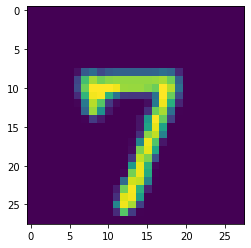

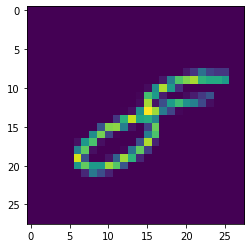

In [15]:
gen = TestImgGenSequence(1)
x,y = gen.gen_test_data(2)
print(x[0].shape)
plt.imshow(x[0])
plt.show()
plt.imshow(x[1])
img1, img2 = x

(28, 28, 1)


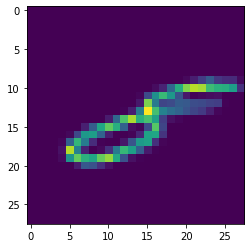

In [16]:
fimg = img2.reshape(28, 28,1)
dgen = tf.keras.preprocessing.image.ImageDataGenerator()
iim = dgen.apply_transform(fimg, {'shear':1, 'zx':1.2, 'zy':0.9})
print(iim.shape)
plt.imshow(iim)

In [27]:
act = 'relu'
pad = 'same'
strd = 1
input_layer = tf.keras.Input(shape = (OUTER_IMG_SZ, OUTER_IMG_SZ,1))
_ = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation = act, padding = pad, strides=2)(input_layer)
_ = tf.keras.layers.Conv2D(filters=8*2, kernel_size=3, activation = act, padding = pad, strides=strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=8*3, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=8*4, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=8*4, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=8*5, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_) 
common_layer = tf.keras.layers.Flatten()(_)
#One output layer per digit
output_layers = {}
output_loss_fns = {}
output_metrics = {}
for op_l in range(GRID_SIDE ** 2):
    layer_name = "output_digit_" + str(op_l)
    output_layers[op_l] = tf.keras.layers.Dense(10, activation = 'softmax', name=layer_name)(common_layer)
    output_loss_fns[op_l] = tf.keras.losses.CategoricalCrossentropy()
    output_metrics[op_l] = 'accuracy'

model = tf.keras.Model(inputs=input_layer, outputs = output_layers, name="digit_recognizer")
model.compile(optimizer=tf.keras.optimizers.Adamax(),
             loss = output_loss_fns,
             metrics = ['accuracy'] )
model.summary()

Model: "digit_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 7, 24)          3480      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 32)          6944      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 3, 32)     

In [28]:
training_gen = TestImgGenSequence(TRAIN_SIZE)
validation_gen = TestImgGenSequence(TEST_SIZE)

In [ ]:
%%time

model.fit(x = training_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/50
97/97 [==============================] - 3s 27ms/step - loss: 1.9888 - accuracy: 0.3305
Epoch 2/50
97/97 [==============================] - 3s 27ms/step - loss: 0.8260 - accuracy: 0.7852
Epoch 3/50
97/97 [==============================] - 3s 27ms/step - loss: 0.4304 - accuracy: 0.8712
Epoch 4/50
97/97 [==============================] - 3s 27ms/step - loss: 0.3226 - accuracy: 0.9013
Epoch 5/50
97/97 [==============================] - 3s 27ms/step - loss: 0.2729 - accuracy: 0.9181
Epoch 6/50
97/97 [==============================] - 3s 27ms/step - loss: 0.2362 - accuracy: 0.9285
Epoch 7/50
97/97 [==============================] - 3s 27ms/step - loss: 0.2140 - accuracy: 0.9355
Epoch 8/50
97/97 [==============================] - 3s 27ms/step - loss: 0.1970 - accuracy: 0.9409
Epoch 9/50
97/97 [==============================] - 3s 27ms/step - loss: 0.1816 - accuracy: 0.9448
Epoch 10/50
97/97 [==============================] - 3s 27ms/step - loss: 0.1740 - accuracy: 0.9477
Epoch 11/

In [9]:
model.evaluate(x=validation_gen, y=None)

9/9 [==============================] - 0s 9ms/step - loss: 0.9097 - accuracy: 0.6613


[0.9097317457199097, 0.6613498330116272]